In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf OptimalRepresentationRL
!git clone https://github.com/AdrienCourtois/OptimalRepresentationRL > /dev/null 2>&1

!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append('./OptimalRepresentationRL')
sys.path.append('./mvarl_hands_on/utils')

from AVFManager import AVFManager
from MDPs.MDPTwoRoom import MDPTwoRoom
from MDPs.MDPFourRoom import MDPFourRoom

from utils.evaluate_V import evaluate_V
from utils.get_optimal_V import get_optimal_V
from utils.get_naive_V import get_naive_V

from cliffwalk import CliffWalk

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch.multiprocessing as mp

# Definition of the MDP

In [0]:
class MDPCliffWalk(CliffWalk):
    def __init__(self):
        super(MDPCliffWalk, self).__init__(proba_succ=0.98)

        self.P = torch.from_numpy(self.P)
        self.r = torch.from_numpy(self.R).mean(2).mean(1)[:,None].float()

        self.n_states = self.P.size(0)
        self.n_actions = self.P.size(1)

        self.is_cuda = False

        self.gamma = 0.8
    
    def evaluate(self, V):
        rewards = []
        nb_errors = 0

        for i in range(self.n_states):
            error, reward = evaluate_V(V, self, state_start=i)

            nb_errors += error
            rewards.append(reward)
        
        return nb_errors, rewards

MDP = MDPCliffWalk()
MDP = MDPFourRoom()

# Get optimal V

In [0]:
V_true = get_optimal_V(MDP)
#evaluate_V(V_true, MDP, render=True)

# Model

In [0]:
class Phi(nn.Module):
    def __init__(self, MDP, n_out, n_hidden=512):
        super(Phi, self).__init__()

        self.MDP = MDP

        self.n_out = n_out
        self.n_hidden = n_hidden

        self.fc1 = nn.Linear(self.MDP.n_states, self.n_hidden)
        self.fc2 = nn.Linear(self.n_hidden, self.n_out)

        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class Model(nn.Module):
    def __init__(self, MDP, n_out=100):
        super(Model, self).__init__()

        self.MDP = MDP
        self.n_out = n_out

        self.phi = Phi(self.MDP, self.n_out)
        self.theta = nn.Linear(self.n_out, 1)
        
        self.optim_phi = self.phi.optim
        self.optim_theta = torch.optim.Adam(self.theta.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = F.leaky_relu(self.phi(x))
        x = self.theta(x)

        return x

# Optimization

In [0]:
# Hyper parameters #
K = 100
n_iter = 500

losses_bellman = []
losses_cum = []
metrics = []
metrics2 = []

r = torch.from_numpy(MDP.R).mean(2)

model = Model(MDP)

100
200
300
400
356.1894540786743


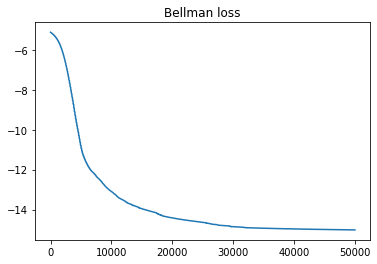

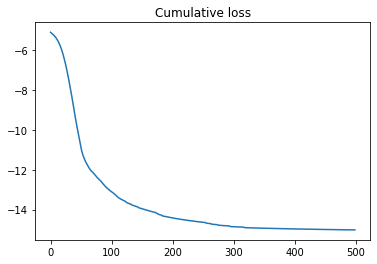

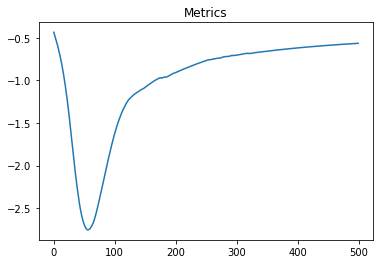

In [40]:
alphas = (1-MDP.gamma) * np.power(MDP.gamma, np.arange(K-2, -2, -1)) / (1 - MDP.gamma ** (K+1))

for i in range(n_iter):
    cum_loss = 0

    for k in range(K):
        V = model(torch.eye(MDP.n_states))[:,0]

        # Compute TV
        Q = r + MDP.gamma * (MDP.P * V[None,None]).sum(2)
        TV = Q.max(1).values
        
        # Loss
        bellman_loss = nn.SmoothL1Loss()(V, TV)
        cum_loss += alphas[k] * bellman_loss

        # Update theta
        bellman_loss.backward(retain_graph=True)
        model.optim_theta.step()
        model.optim_theta.zero_grad()

        losses_bellman.append(bellman_loss.item())

    # Update phi
    cum_loss.backward()
    model.optim_phi.step()
    model.optim_phi.zero_grad()

    # Calculate metric
    V = model(torch.eye(MDP.n_states))[:,0]
    metrics.append(nn.MSELoss()(V, V_true.float()).item())
    #metrics2.append(np.mean(MDP.evaluate(V)[1]))

    if i % 100 == 0 and i > 0:
        print(i)

    losses_cum.append(cum_loss.item())

plt.plot(np.log(losses_bellman))
plt.title("Bellman loss")
plt.show()

plt.plot(np.log(losses_cum))
plt.title("Cumulative loss")
plt.show()

plt.plot(np.log(metrics))
plt.title("Metrics")
plt.show()

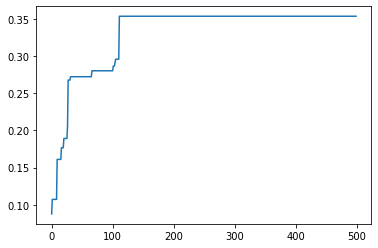

In [32]:
plt.plot(metrics2)
plt.show()

0.03045885313746373
0.03804347826086956


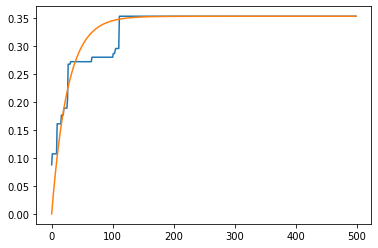

In [33]:
r = np.max(metrics2)
C = np.sum(1- metrics2/r)
alpha = - np.log(1-1/C)

print(alpha)
alpha = 1.4 / (MDP.gamma * MDP.n_states)
print(alpha)

plt.plot(metrics2)
plt.plot(r * (1 - np.exp(-alpha * np.arange(len(metrics2)))))
plt.show()

# Evaluate

In [65]:
V = model(torch.eye(MDP.n_states))[:,0]
nb_errors, rewards = MDP.evaluate(V)

print("CEVIM")
print("Number of errors:", nb_errors, "; Mean reward:", np.mean(rewards), "; Std reward:", np.std(rewards))

CEVIM
Number of errors: 0 ; Mean reward: 0.8978908300425263 ; Std reward: 0.09888198948583073


In [42]:
t0 = time()
V_naive = get_naive_V(MDP, n_iter=500*100)
print(time()-t0)
nb_errors, rewards = MDP.evaluate(V_naive)

print("Naive V")
print("Number of errors:", nb_errors, "; Mean reward:", np.mean(rewards), "; Std reward:", np.std(rewards))

364.4719183444977
Naive V
Number of errors: 103 ; Mean reward: 0.0 ; Std reward: 0.0


In [9]:
V_true = get_optimal_V(MDP)
nb_errors, rewards = MDP.evaluate(V_true)

print("Optimal V")
print("Number of errors:", nb_errors, "; Mean reward:", np.mean(rewards), "; Std reward:", np.std(rewards))

Optimal V
Number of errors: 0 ; Mean reward: 0.8978908300425263 ; Std reward: 0.09888198948583073
